This is pytorch 7L.py


In [1]:
# Continue with regular imports 
import matplotlib.pyplot as plt 
import torch 
import torchvision 

from torch import nn 
from torchvision import transforms 



/home/rudgh1999/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rudgh1999/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Set seeds 
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    

In [4]:
import os 
import zipfile 
from pathlib import Path 
import requests 

def download_data(source:str,
                  destination:str,
                  remove_source: bool = True) -> Path:
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination 

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one.")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data 
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)
        
        # Unzip pizza, steak , sushi data 
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file 
            if remove_source:
                os.remove(data_path / target_file)
    return image_path 

image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",destination="pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
from going_modular import data_setup
# Setup directories 
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

# Create transform pipeline manually 
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually create transforms : {manual_transforms}")

# Create data loaders 

# Create data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir = test_dir,
                                                                               transform= manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Manually create transforms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f85de760640>,
 ['pizza', 'steak', 'sushi'])

In [6]:
# Setup dirs 
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader , class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f8624593a90>,
 ['pizza', 'steak', 'sushi'])

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Freeze all base layers by setting required_grad attribute to False 
for param in model.features.parameters():
    param.requires_grad = False 

# Since we're creating a new layer with random weights (torch.nn.Linear), let's set the seeds 
set_seeds()

# Update the classifier head to suit our problem 
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device)
)

In [9]:
# Define loss and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
from torch.utils.tensorboard import SummaryWriter 

# # Create a writer with all default settings 
# writer = SummaryWriter()

In [11]:
from typing import Dict, List 
from tqdm.auto import tqdm 

from going_modular.engine import train_step, test_step

def train(model : torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader : torch.utils.data.DataLoader,
        optimizer : torch.optim.Optimizer,
        loss_fn : torch.nn.Module,
        epochs : int,
        device : torch.device,
        writer : torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    # Create empty results dictionary 
    results = {"train_loss": [],
    "train_acc" : [],
    "test_loss" : [],
    "test_acc" : []}

    # Loop through training and testing steps for a number of epochs 
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model= model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        test_loss, test_acc = test_step(model = model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device = device)

        # Print out what's happening 
        print(f"Epoch: {epoch + 1} |" f"train_loss : {train_loss:.4f} |" f"train_acc : {train_acc} |" f"test_loss : {test_loss:.4f} |" f"test_acc : {test_acc:.4f}")

        # Update results dictionary 
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New : Use the writer parameter to track experiments ### 
        # See if there's a writer, if so, log to it 
        if writer:
            # Add results to SummaryWriter 
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict = {"train_loss": train_loss, "test_loss":test_loss},global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict = {"train_acc": train_acc, "test_acc":test_acc},global_step=epoch)
            # Close the Writer
            writer.close()
        else:
            pass
        ### End new ### 

    # Return the filled results at the end of the epochs 
    return results 
    
        

/home/rudgh1999/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Example code to run in Jupyter or Google Colab Notebook 
# %load_ext tensorboard 
# %tensorboard --logdir runs

In [13]:
def create_writer(experiment_name : str,
                  model_name : str,
                  extra : str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    from datetime import datetime 
    import os 

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") 

    if extra:
        # Create log directory path 
        log_dir = os.path.join("runs", timestamp , experiment_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter , saving to: {log_dir} ...")
    return SummaryWriter(log_dir=log_dir)


In [14]:
# Create an example writer 
# example_writer = create_writer(experiment_name= "data_10_percent",
#                                model_name= "effnetb0",
#                                extra = "5_epochs")


In [15]:
from going_modular import data_setup 
import os
import zipfile 
from pathlib import Path 
import requests 
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",destination="pizza_steak_sushi")

data_20_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip", destination= "pizza_steak_sushi_20_percent")


[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [16]:
# Setup training directory paths 
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"




In [17]:
from torchvision import transforms 

# Create a transform to normalize data distribution to be inline with ImageNet 
normalize = transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                 std = [0.229,0.224, 0.225])

# Compose transforms into a pipeline 
simple_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [18]:
BATCH_SIZE = 32
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir_10_percent,
                                                                                          test_dir = test_dir,
                                                                                          transform= simple_transform,
                                                                                          batch_size= BATCH_SIZE)

# Create 20% training and test data DataLoaders 
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir_20_percent,
                                                                                          test_dir= test_dir,
                                                                                          transform= simple_transform,
                                                                                          batch_size= BATCH_SIZE)


In [19]:
import torchvision 
from torchinfo import summary 

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models 
summary(model= effnetb2,
        input_size=(32,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width= 20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [20]:
import torchvision 
from torch import nn 
device = "cuda" if torch.cuda.is_available() else "cpu"
# Get num out features ( one for each class pizza , steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor 
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device 
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers 
    for param in model.features.parameters():
        param.requires_grad = False 

    # 3. Set the seeds 
    set_seeds()

    # 4. Change the classifier head 
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280,
                  out_features=OUT_FEATURES).to(device)
    )

    # 5. Give the model a name 
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device 
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 
    model = torchvision.models.efficientnet_b2(weights = weights).to(device)

    # 2. Freeze the base model layers 
    for param in model.features.parameters():
        param.requires_grad = False 

    
    # 3. Set the seeds 
    set_seeds()

    # 4. Change the classifier head 
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features= 1408,
                  out_features=OUT_FEATURES)    
        ).to(device)
    
    # 5. Give the model a name 
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model 

In [21]:
effnetb0 = create_effnetb0()
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.


In [22]:
# 1 . Create epochs list 
num_epochs = [5, 10]

# 2. Create model list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders 
train_dataloader = {"data_10_percent" : train_dataloader_10_percent, "data_20_percent" : train_dataloader_20_percent}



In [23]:
# %%time 
from going_modular.utils import save_model 
"""
# 1. Set the random seeds 
set_seeds(seed=42)

# 2. Keep track of experiment numbers 
experiment_number = 0 

# 3. Loop through each DataLoader 
for dataloader_name, train_dataloader in train_dataloader.items():

    # 4. Loop through each number of epochs 
    for epochs in num_epochs:

        # 5. Loop through each model and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs 
            experiment_number += 1
            print(f"[INFO] Experiment number : {experiment_number}")
            print(f"[INFO] Model : {model_name}")
            print(f"[INFO] DataLoader : {dataloader_name}")
            print(f"[INFO] Number of epochs : {epochs}")

            # 7. Select the model 
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()


            # 8. Create a new loss and optimizer for every model 
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments 
            train(model= model,
                  train_dataloader= train_dataloader,
                  test_dataloader= test_dataloader,
                  optimizer= optimizer,
                  loss_fn= loss_fn,
                  epochs= epochs,
                  device= device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name= model_name,
                                       extra= f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model 
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model = model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")



"""

'\n# 1. Set the random seeds \nset_seeds(seed=42)\n\n# 2. Keep track of experiment numbers \nexperiment_number = 0 \n\n# 3. Loop through each DataLoader \nfor dataloader_name, train_dataloader in train_dataloader.items():\n\n    # 4. Loop through each number of epochs \n    for epochs in num_epochs:\n\n        # 5. Loop through each model and create a new model based on the name\n        for model_name in models:\n\n            # 6. Create information print outs \n            experiment_number += 1\n            print(f"[INFO] Experiment number : {experiment_number}")\n            print(f"[INFO] Model : {model_name}")\n            print(f"[INFO] DataLoader : {dataloader_name}")\n            print(f"[INFO] Number of epochs : {epochs}")\n\n            # 7. Select the model \n            if model_name == "effnetb0":\n                model = create_effnetb0()\n            else:\n                model = create_effnetb2()\n\n\n            # 8. Create a new loss and optimizer for every model \

In [24]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model stae_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

Cehck the model file size

In [25]:
# Check the model file size
from pathlib import Path 

# Get the model size in bytes then convert to megabytes 
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


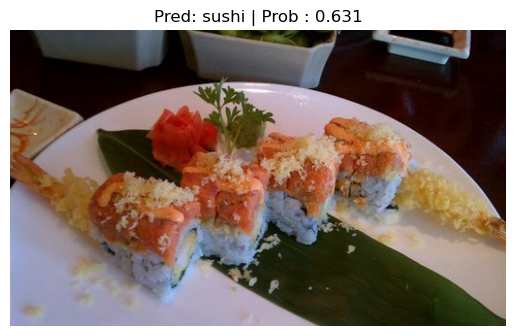

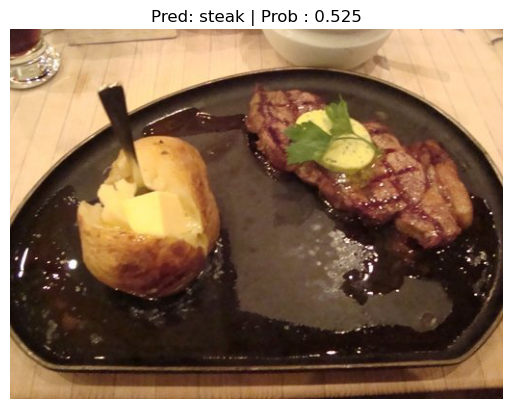

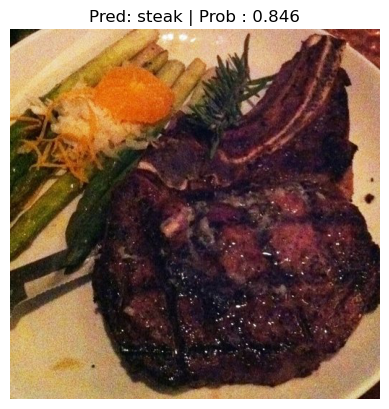

In [26]:
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set 
import random 
num_images_to_plot = 3 
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))

test_image_path_sample = random.sample(population= test_image_path_list, k= num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model = best_model,
                        image_path = image_path,
                        class_names=class_names,
                        image_size=(224,224))

data/04-pizza-dad.jpeg already exists, skipping download.


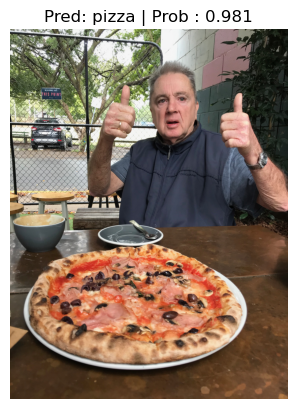

In [29]:
import requests 
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model = best_model,
                    image_path = custom_image_path,
                    class_names=class_names)